In [2]:
# importing all the imports needed for this phase
# data manipulation
import pandas as pd
import numpy as np

# visuals
import matplotlib.pyplot as plt
import seaborn as sns

# personal import
import acquire as a
import prepare as p
import explore as e
import env
import MODEL as m


#stats import
from scipy import stats

# ML stuff:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, \
export_text, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

> ACQUIRE

In [8]:
# creating the url and creating SQL query to pull data
url = env.get_db_url('telco_churn')
query = "select * from customers join contract_types using(contract_type_id) join internet_service_types using(internet_service_type_id) join payment_types using(payment_type_id)"

In [12]:
# pulling database using read sql function
df = a.get_telco_data()

this file exists, reading csv


In [13]:
# checking the size of the data
df.shape

(7043, 24)

>there are 7043 rows and 24 columns

from this data i can initially see what are some columns that can be important and some that are not

important
> gender
> tenure
> senior
> monthly

unimportant
> payment_type_id
> internet_service_type
> contract_type_id
> customer_id ( theres already an index)  

>PREPARE

In [14]:
# using prep telco to clan data
df =p.prep_telco(df)

In [15]:
df.shape

(7032, 16)

In [16]:
encoded_df = p.preprocess_data(df)

now split the data

In [17]:
# splitting the data
train, validate, test = p.splitting_data(encoded_df, 'churn')

In [18]:
train.shape, validate.shape, test.shape

((4219, 16), (1406, 16), (1407, 16))

### preprocess

In [11]:
train.head()

,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,streaming_tv,streaming_movies,monthly_charges,total_charges,churn,has_add_ons,has_internet,monthly_contract,automatic_payment,is_male
5671,1,0,0,54,1,0,0,1,65.25,3529.95,0,1,1,0,1,1
6843,0,0,0,2,1,0,0,0,70.30,144.00,0,0,1,1,0,1
2325,0,1,1,71,1,0,1,1,104.65,7288.40,0,1,1,0,1,1
6323,0,0,0,1,1,0,0,0,44.95,44.95,0,0,1,1,0,1
3081,1,1,0,12,1,0,1,1,79.20,943.85,0,1,1,0,0,0


In [19]:
# created a for loop to visualy see the unique values in each columns 
# and added to binary if 2 and multiclass if more
cat_var=[]
cont_var= []
for column in train.columns:
    unique_values = train[column].unique()
    print(f"{column}': {unique_values}")
    if train[column].nunique() == 2:
        cat_var.append(column)
    elif train[column].nunique() > 2:
        cont_var.append(column)

senior_citizen': [1 0]
partner': [0 1]
dependents': [0 1]
tenure': [54  2 71  1 12 46 70 16 56 17  5 29 52 21 25 27 66  9  4 13 65  8 20 28
 61 10 26 11 50 34 55 59 45 60 53 31 69 18 68 72 38 36 37 22 42  6 32 57
 67 19  3 43 14 49  7 35 44 15 47 24 33 62 23 64 30 63 48 39 41 51 58 40]
phone_service': [1 0]
multiple_lines': [0 1]
streaming_tv': [0 1]
streaming_movies': [1 0]
monthly_charges': [ 65.25  70.3  104.65 ...  36.05  96.25 112.35]
total_charges': [3529.95  144.   7288.4  ...  595.05 5485.5   514.75]
churn': [0 1]
has_add_ons': [1 0]
has_internet': [1]
monthly_contract': [0 1]
automatic_payment': [1 0]
is_male': [1 0]


In [11]:
yn=['partner','dependents','phone_service']

now that i got a see which columns are what going to start seperating them to encod

In [12]:
cont_var

['tenure', 'monthly_charges', 'total_charges']

In [13]:
cat_var

['senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'streaming_tv',
 'streaming_movies',
 'churn',
 'has_add_ons',
 'has_internet',
 'monthly_contract',
 'automatic_payment',
 'is_male']

> working on the multiclass right now

In [44]:
# switching internet to 1 or 0
train['has_internet'] = train['internet_service_type'].apply(lambda x: 0 if x == 'None' else 1)

KeyError: 'internet_service_type'

In [45]:
train.head()

,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,streaming_tv,streaming_movies,monthly_charges,total_charges,churn,has_add_ons,has_internet,monthly_contract,automatic_payment,is_male
5671,1,0,0,54,1,0,0,1,65.25,3529.95,0,1,1,0,1,1
6843,0,0,0,2,1,0,0,0,70.30,144.00,0,0,1,1,0,1
2325,0,1,1,71,1,0,1,1,104.65,7288.40,0,1,1,0,1,1
6323,0,0,0,1,1,0,0,0,44.95,44.95,0,0,1,1,0,1
3081,1,1,0,12,1,0,1,1,79.20,943.85,0,1,1,0,0,0


In [46]:
# deleting the internet service
train.pop('internet_service_type')


KeyError: 'internet_service_type'

In [47]:
# for lines, streaming make them only yes and no to become binary
lines = ['multiple_lines', 'streaming_tv', 'streaming_movies']

In [48]:
# loop to change all 3 at to 1 and 0
for x in lines:
    train[x] = train[x].apply(lambda x: 1 if x == 'Yes' else 0)

In [49]:
# switching contract type to monthly or not
train['monthly_contract'] = train['contract_type'].apply(lambda x: 1 if x == 'Month-to-month' else 0)

KeyError: 'contract_type'

In [50]:
# deleting the contract type col
train.pop('contract_type')

KeyError: 'contract_type'

now turning oayment type to 1 or 0 if its automatic

In [51]:
train['automatic_payment'] = train['payment_type'].apply(lambda x: 1 if 'automatic' in x else 0)


KeyError: 'payment_type'

In [52]:
# now deleting the column
train.pop('payment_type')

KeyError: 'payment_type'

In [53]:
# turned the yes and no rows into 1 (yes) and 0 (no)
for x in yn:
    train[x] = train[x].apply(lambda x: 1 if 'Yes' in x else 0)

TypeError: argument of type 'int' is not iterable

In [ ]:
train.head(10)

In [ ]:
# creating is male variable
train['is_male'] = train['gender'].apply(lambda x: 1 if 'Male' in x else 0)

In [54]:
# now delete the gender 
train.pop('gender')

KeyError: 'gender'

In [55]:
# turning churn into 1 and 0
train['churn'] = train['churn'].apply(lambda x: 1 if 'Yes' in x else 0)

TypeError: argument of type 'int' is not iterable

In [56]:
print(train.dtypes)

senior_citizen         int64
partner                int64
dependents             int64
tenure                 int64
phone_service          int64
multiple_lines         int64
streaming_tv           int64
streaming_movies       int64
monthly_charges      float64
total_charges        float64
churn                  int64
has_add_ons            int64
has_internet           int64
monthly_contract       int64
automatic_payment      int64
is_male                int64
dtype: object


>> finished off turning all binomials in encoding

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 7032 non-null   object 
 1   senior_citizen         7032 non-null   int64  
 2   partner                7032 non-null   int64  
 3   dependents             7032 non-null   int64  
 4   tenure                 7032 non-null   int64  
 5   phone_service          7032 non-null   int64  
 6   multiple_lines         7032 non-null   int64  
 7   streaming_tv           7032 non-null   int64  
 8   streaming_movies       7032 non-null   int64  
 9   monthly_charges        7032 non-null   float64
 10  total_charges          7032 non-null   float64
 11  churn                  7032 non-null   int64  
 12  contract_type          7032 non-null   object 
 13  internet_service_type  7032 non-null   object 
 14  payment_type           7032 non-null   object 
 15  has_add_o

In [58]:
obj_cols = df.columns[[df[col].dtype == 'O' for col in df.columns]]

In [59]:
obj_cols

Index(['gender', 'contract_type', 'internet_service_type', 'payment_type'], dtype='object')

# EXPLORE 

In [14]:
train.head()

,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,streaming_tv,streaming_movies,monthly_charges,total_charges,churn,has_add_ons,has_internet,monthly_contract,automatic_payment,is_male
5671,1,0,0,54,1,0,0,1,65.25,3529.95,0,1,1,0,1,1
6843,0,0,0,2,1,0,0,0,70.30,144.00,0,0,1,1,0,1
2325,0,1,1,71,1,0,1,1,104.65,7288.40,0,1,1,0,1,1
6323,0,0,0,1,1,0,0,0,44.95,44.95,0,0,1,1,0,1
3081,1,1,0,12,1,0,1,1,79.20,943.85,0,1,1,0,0,0


In [15]:
train['churn'].value_counts()

churn
0    3098
1    1121
Name: count, dtype: int64

In [16]:
train.shape

(4219, 16)

In [17]:
df.shape

(7032, 20)

In [18]:
df['churn'].value_counts()

churn
0    5163
1    1869
Name: count, dtype: int64

In [19]:
for column in cont_var:
    print(f"Column: {column}")
    print(df[column].value_counts())
    print("\n")

Column: tenure
tenure
1     613
72    362
2     238
3     200
4     176
71    170
5     133
7     131
8     123
9     119
70    119
12    117
10    116
6     110
13    109
68    100
11     99
15     99
67     98
18     97
69     95
24     94
22     90
66     89
35     88
17     87
23     85
16     80
56     80
64     80
52     80
25     79
26     79
61     76
65     76
60     76
14     76
46     74
19     73
63     72
29     72
27     72
30     72
20     71
62     70
53     70
41     70
32     69
51     68
54     68
50     68
47     68
58     67
49     66
31     65
42     65
57     65
43     65
37     65
34     65
33     64
48     64
55     64
40     64
21     63
45     61
59     60
38     59
28     57
39     56
44     51
36     50
Name: count, dtype: int64


Column: monthly_charges
monthly_charges
20.05     61
19.85     44
19.95     44
19.90     44
19.65     43
          ..
47.60      1
35.25      1
115.85     1
112.40     1
67.85      1
Name: count, Length: 1584, dtype: int64


Colum

In [20]:
for column in cat_var:
    print(f"Column: {column}")
    print(df[column].value_counts())
    print("\n")

Column: senior_citizen
senior_citizen
0    5890
1    1142
Name: count, dtype: int64


Column: partner
partner
0    3639
1    3393
Name: count, dtype: int64


Column: dependents
dependents
0    4933
1    2099
Name: count, dtype: int64


Column: phone_service
phone_service
1    6352
0     680
Name: count, dtype: int64


Column: multiple_lines
multiple_lines
0    4065
1    2967
Name: count, dtype: int64


Column: streaming_tv
streaming_tv
0    4329
1    2703
Name: count, dtype: int64


Column: streaming_movies
streaming_movies
0    4301
1    2731
Name: count, dtype: int64


Column: churn
churn
0    5163
1    1869
Name: count, dtype: int64


Column: has_add_ons
has_add_ons
1    4245
0    2787
Name: count, dtype: int64


Column: has_internet
has_internet
1    5512
0    1520
Name: count, dtype: int64


Column: monthly_contract
monthly_contract
1    3875
0    3157
Name: count, dtype: int64


Column: automatic_payment
automatic_payment
0    3969
1    3063
Name: count, dtype: int64


Column: is

# initual visuals

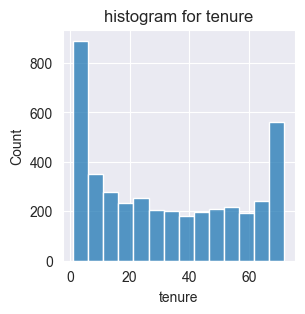

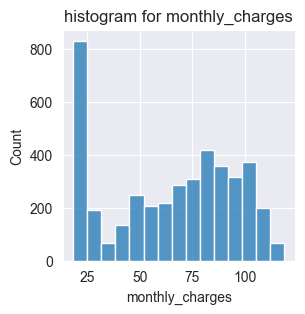

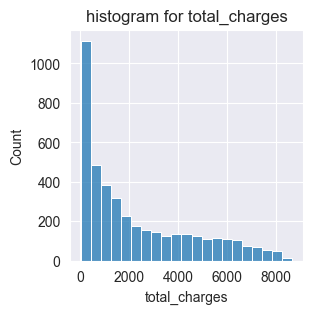

In [21]:
# histogram for cont variables
for x in cont_var:
    plt.figure(figsize= (3, 3))
    sns.histplot(train, x=x)
    plt.title(f'histogram for {x}')

senior_citizen
senior_citizen
0    5890
1    1142
Name: count, dtype: int64
senior_citizen
0    0.8376
1    0.1624
Name: proportion, dtype: float64


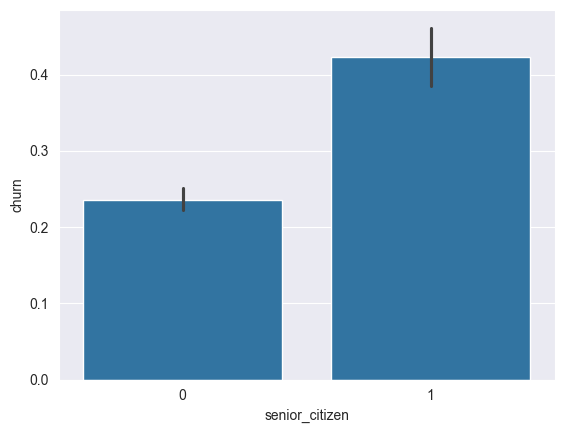


partner
partner
0    3639
1    3393
Name: count, dtype: int64
partner
0    0.517491
1    0.482509
Name: proportion, dtype: float64


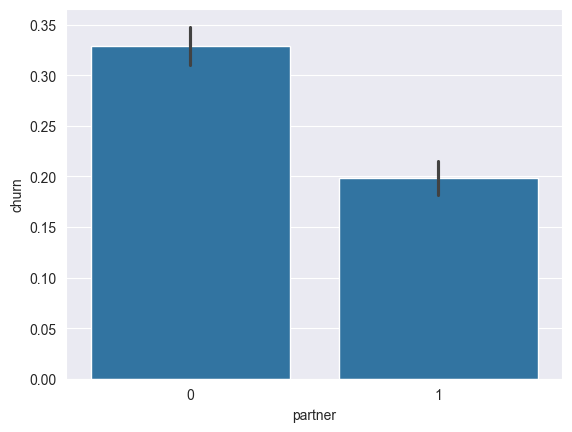


dependents
dependents
0    4933
1    2099
Name: count, dtype: int64
dependents
0    0.701507
1    0.298493
Name: proportion, dtype: float64


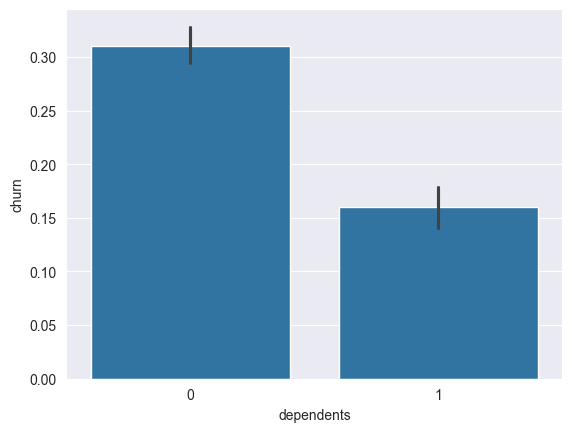


phone_service
phone_service
1    6352
0     680
Name: count, dtype: int64
phone_service
1    0.903299
0    0.096701
Name: proportion, dtype: float64


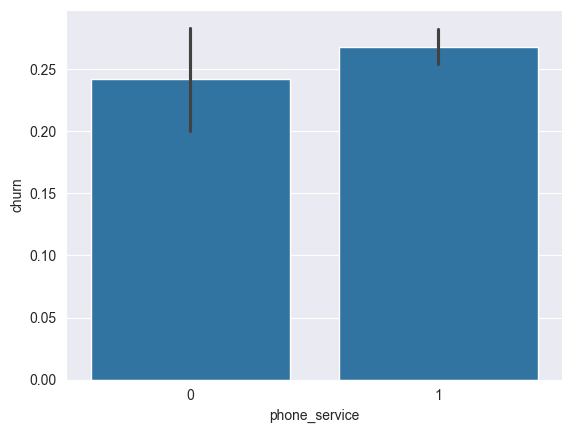


multiple_lines
multiple_lines
0    4065
1    2967
Name: count, dtype: int64
multiple_lines
0    0.578072
1    0.421928
Name: proportion, dtype: float64


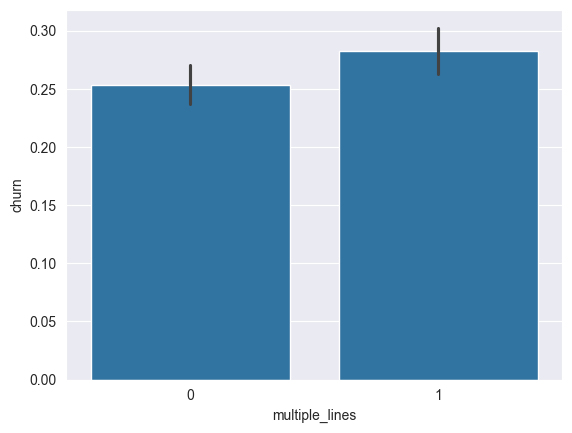


streaming_tv
streaming_tv
0    4329
1    2703
Name: count, dtype: int64
streaming_tv
0    0.615614
1    0.384386
Name: proportion, dtype: float64


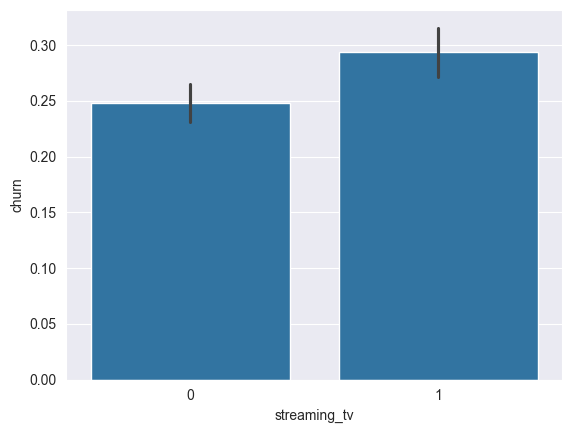


streaming_movies
streaming_movies
0    4301
1    2731
Name: count, dtype: int64
streaming_movies
0    0.611633
1    0.388367
Name: proportion, dtype: float64


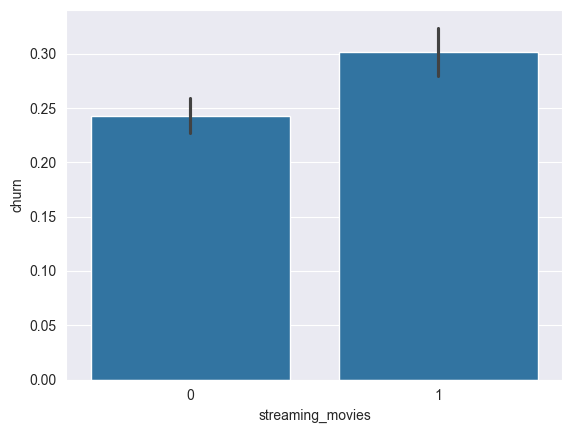


churn
churn
0    5163
1    1869
Name: count, dtype: int64
churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64


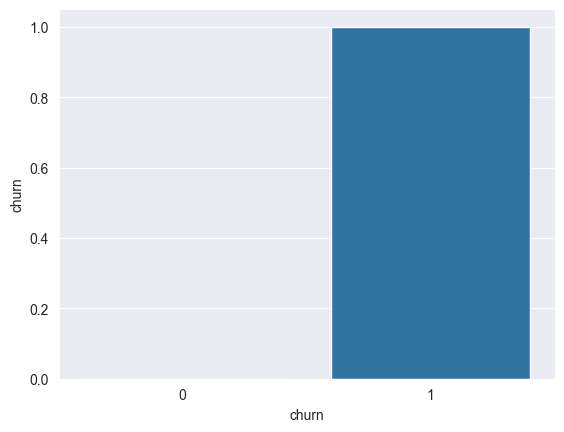


has_add_ons
has_add_ons
1    4245
0    2787
Name: count, dtype: int64
has_add_ons
1    0.603669
0    0.396331
Name: proportion, dtype: float64


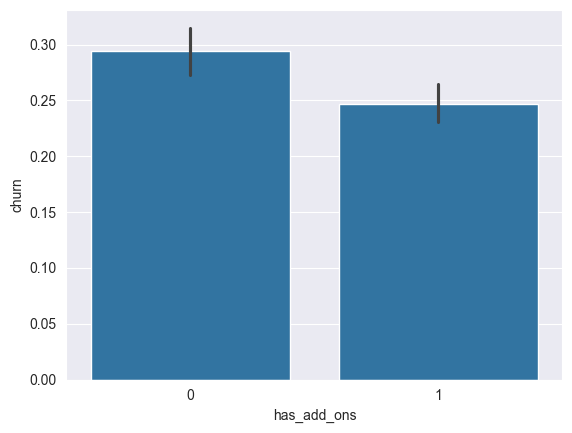


has_internet
has_internet
1    5512
0    1520
Name: count, dtype: int64
has_internet
1    0.783845
0    0.216155
Name: proportion, dtype: float64


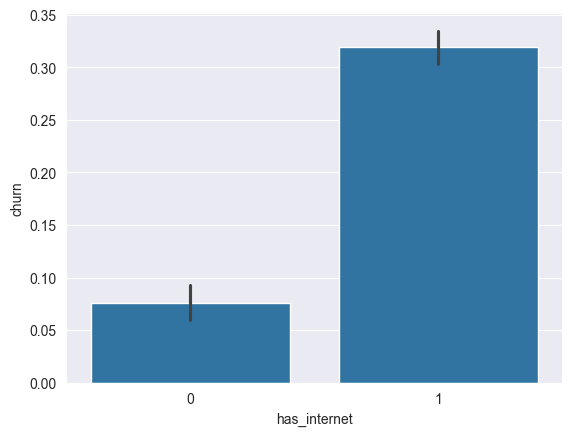


monthly_contract
monthly_contract
1    3875
0    3157
Name: count, dtype: int64
monthly_contract
1    0.551052
0    0.448948
Name: proportion, dtype: float64


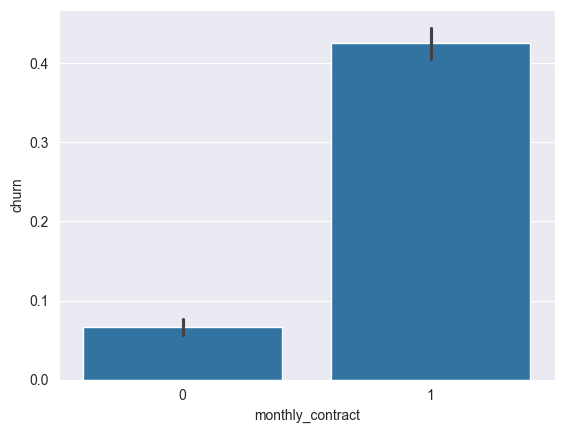


automatic_payment
automatic_payment
0    3969
1    3063
Name: count, dtype: int64
automatic_payment
0    0.56442
1    0.43558
Name: proportion, dtype: float64


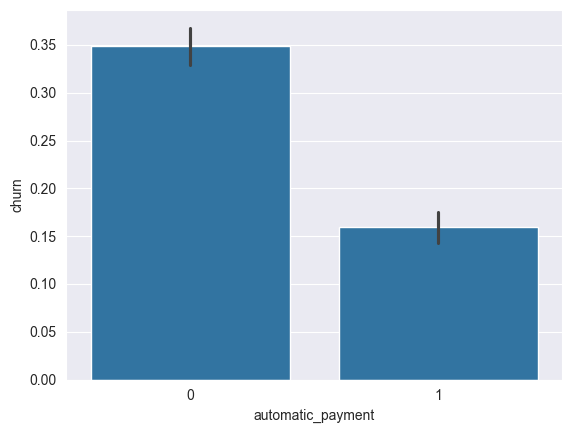


is_male
is_male
1    3549
0    3483
Name: count, dtype: int64
is_male
1    0.504693
0    0.495307
Name: proportion, dtype: float64


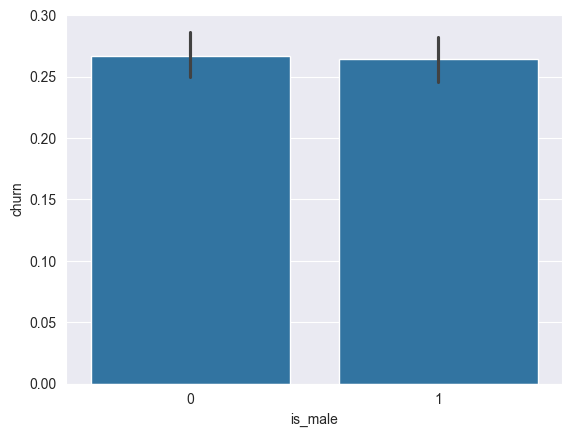

In [22]:
# bar charts for cat variables
for col in cat_var:
    print(col)
    print(df[col].value_counts())
    print(df[col].value_counts(normalize=True))
    sns.barplot(data=train, y='churn', x=col)
    plt.show()
    print()

# HYPOTHESIS 

In [23]:
for x in cat_var:
    print(f' Does the customer column "{x}" affect whether or not someone churn?')

 Does the customer column "senior_citizen" affect whether or not someone churn?
 Does the customer column "partner" affect whether or not someone churn?
 Does the customer column "dependents" affect whether or not someone churn?
 Does the customer column "phone_service" affect whether or not someone churn?
 Does the customer column "multiple_lines" affect whether or not someone churn?
 Does the customer column "streaming_tv" affect whether or not someone churn?
 Does the customer column "streaming_movies" affect whether or not someone churn?
 Does the customer column "churn" affect whether or not someone churn?
 Does the customer column "has_add_ons" affect whether or not someone churn?
 Does the customer column "has_internet" affect whether or not someone churn?
 Does the customer column "monthly_contract" affect whether or not someone churn?
 Does the customer column "automatic_payment" affect whether or not someone churn?
 Does the customer column "is_male" affect whether or not som

## Does the customer column "senior_citizen" affect whether or not someone churn?

<Axes: xlabel='senior_citizen', ylabel='churn'>

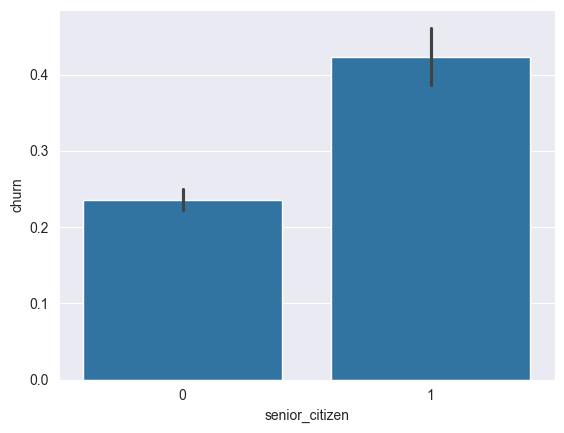

In [24]:
sns.barplot(data=train, y='churn', x='senior_citizen')

### we can see that if someone is a senior citizen there is a higher churn rate

H0= there is NO relationship between senior citizen and churn
Ha= there IS relationship between senior citizen and churn

In [25]:
alpha = 0.05

In [26]:
observed = pd.crosstab(train.senior_citizen, train.churn)
observed

churn,0,1
senior_citizen,,
0,2708,835
1,390,286


In [27]:
chi2, p, dof, expected = stats.chi2_contingency(observed)

In [28]:
p

8.206605132251275e-24

In [29]:
# check for each alpha:
if p < alpha:
    print(f'reject the null hypothesis for')

else:
    print(f'fail to reject the null hypothesis')


reject the null hypothesis for


My p-value is less than alpha, therefore, we reject the null hypothesis.

we can conclude that there is a relationship between pclass and survived.

We confirmed there is a relationship between senior_citizen and churn.

### Does the customer column "automatic_payment" affect whether or not someone churn?

H0= there is NO relationship between automatic_payment and churn 
Ha= there IS relationship between automatic_payment and churn

<Axes: xlabel='automatic_payment', ylabel='churn'>

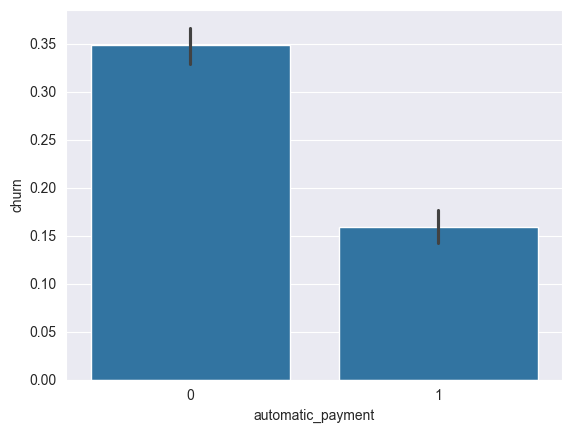

In [41]:
sns.barplot(data=train,y=train.churn, x=train.automatic_payment)

In [42]:
observed = pd.crosstab(train.churn, train.automatic_payment)
observed

automatic_payment,0,1
churn,,
0,1543,1555
1,826,295


In [43]:
#chi2 returns 4 variables
chi2, p, dof, expected = stats.chi2_contingency(observed)

In [44]:
p

3.802293916720818e-43

In [45]:
# check for each alpha:
if p < alpha:
    print(f'reject the null hypothesis for')

else:
    print(f'fail to reject the null hypothesis')

reject the null hypothesis for


My p-value is less than alpha, therefore, we reject the null hypothesis.
we can conclude that there is a relationship between automatic_payment and churn.

### Does the customer column "monthly_payment" affect whether or not someone churn?

H0= there is NO relationship between monthly_payment and churn 
Ha= there IS relationship between monthly_payment and churn

<Axes: xlabel='monthly_contract', ylabel='churn'>

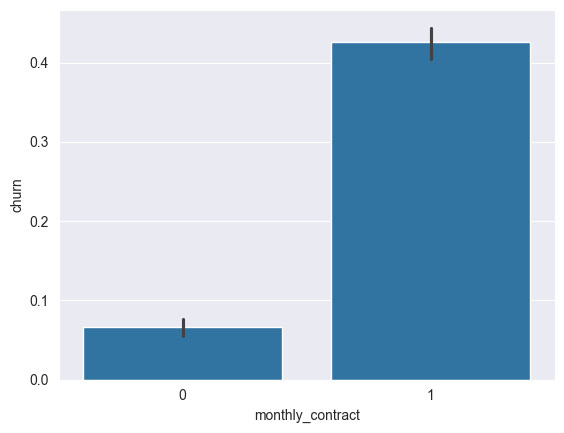

In [47]:
sns.barplot(data=train,y=train.churn, x=train.monthly_contract)

In [48]:
observed = pd.crosstab(train.churn, train.monthly_contract)
observed

monthly_contract,0,1
churn,,
0,1755,1343
1,124,997


In [49]:
chi2, p, dof, expected = stats.chi2_contingency(observed)

In [50]:
# check for each alpha:
if p < alpha:
    print(f'reject the null hypothesis for')

else:
    print(f'fail to reject the null hypothesis')

reject the null hypothesis for


My p-value is less than alpha, therefore, we reject the null hypothesis.
we can conclude that there is a relationship between monthly_contract and churn.

## Explore Conclusions

We saw there was a relationship between passenger senior_citizen, monthly_contract, automatic)payment and whether or not they churned.

here are some ideas to possibly lower the churn rate. 

Senior Citizens:
>Tailored Communication: Customize communication and support for senior citizens. This could include clearer, larger print on bills and correspondence, or a dedicated support line.
    
Monthly Contracts:
>Incentivize Longer Contracts: Offer incentives for customers to switch from monthly to longer-term contracts, such as annual plans. These could be discounts, additional features, or loyalty rewards.
    
Automatic Payment Methods:
>Promote Automatic Payments: Encourage customers to use automatic payment methods by offering discounts or additional benefits. Make sure the process of setting up automatic payments is simple and secure.

# MODEL

### baseline

In [20]:
1 - train['churn'].mean() 

0.7342972268310026

our basleine accuracy is 73%

### decision tree`

In [21]:
# creating my x and y for models
X_train, y_train = train.drop(columns='churn'), train.churn
X_val, y_val = validate.drop(columns='churn'), validate.churn
X_test, y_test = test.drop(columns='churn'), test.churn

In [22]:
# creating the model!

clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10)

In [23]:
# create the model
clf


DecisionTreeClassifier(max_depth=3, min_samples_leaf=10)

In [24]:
# fit the model
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=10)

In [25]:
# use the model
clf.predict(X_train)[:10]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [26]:
#store my predicted values
y_pred = clf.predict(X_train)
y_pred[:10]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
# accuracy_score
accuracy_score(y_pred.y_true, y_pred.dt_one)

AttributeError: 'numpy.ndarray' object has no attribute 'y_true'

our first model has a 79% accuracy compared to our baseline which was 73%

### evaluate the model

In [67]:
cf.print_classification_metrics(y_train, y_pred)

Classification Metrics:
Accuracy: 0.79
True Positive Rate: 0.36
False Positive Rate: 0.06
True Negative Rate: 0.94
False Negative Rate: 0.64
Precision: 0.70
Recall: 0.36
F1 Score: 0.48

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.94      0.87      3098
           1       0.70      0.36      0.48      1121

    accuracy                           0.79      4219
   macro avg       0.75      0.65      0.67      4219
weighted avg       0.78      0.79      0.76      4219


In [77]:
for x in range(1,21):
    #create the object
    tree = DecisionTreeClassifier(max_depth=x)
    
    #fit the object
    tree.fit(X_train, y_train) #fit only on TRAIN DATA!
    
    #calculate the accuracy
    acc = tree.score(X_train, y_train)
    
    print(f'with a max depth of {x}, the accuracy is {round(acc,2)}')

with a max depth of 1, the accuracy is 0.73
with a max depth of 2, the accuracy is 0.76
with a max depth of 3, the accuracy is 0.79
with a max depth of 4, the accuracy is 0.79
with a max depth of 5, the accuracy is 0.8
with a max depth of 6, the accuracy is 0.81
with a max depth of 7, the accuracy is 0.82
with a max depth of 8, the accuracy is 0.84
with a max depth of 9, the accuracy is 0.85
with a max depth of 10, the accuracy is 0.88
with a max depth of 11, the accuracy is 0.9
with a max depth of 12, the accuracy is 0.92
with a max depth of 13, the accuracy is 0.93
with a max depth of 14, the accuracy is 0.95
with a max depth of 15, the accuracy is 0.96
with a max depth of 16, the accuracy is 0.97
with a max depth of 17, the accuracy is 0.98
with a max depth of 18, the accuracy is 0.98
with a max depth of 19, the accuracy is 0.99
with a max depth of 20, the accuracy is 0.99


In [42]:
for x in range(1,14):
    #create the object
    tree = DecisionTreeClassifier(max_depth=x)
    
    #fit the object
    tree.fit(X_train, y_train) 
    
    #calculate the accuracy for train
    acc = tree.score(X_train, y_train)
    
    #calculate the accuracy for validate
    acc_v = tree.score(X_val, y_val)
    
    print(f'max depth of {x}, the accuracy train = {round(acc,2)}, val = {round(acc_v,2)}')

max depth of 1, the accuracy train = 0.73, val = 0.73
max depth of 2, the accuracy train = 0.76, val = 0.75
max depth of 3, the accuracy train = 0.79, val = 0.79
max depth of 4, the accuracy train = 0.79, val = 0.8
max depth of 5, the accuracy train = 0.8, val = 0.8
max depth of 6, the accuracy train = 0.81, val = 0.79
max depth of 7, the accuracy train = 0.82, val = 0.79
max depth of 8, the accuracy train = 0.83, val = 0.77
max depth of 9, the accuracy train = 0.85, val = 0.76
max depth of 10, the accuracy train = 0.87, val = 0.76
max depth of 11, the accuracy train = 0.89, val = 0.75
max depth of 12, the accuracy train = 0.91, val = 0.74
max depth of 13, the accuracy train = 0.93, val = 0.74


### max depth of 5 is the best fit for this data

### random forrest

In [81]:
# creating the random forrest module
rf = RandomForestClassifier(max_depth=10)

In [83]:
# fitting the module
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10)

In [84]:
# using the random forrest
y_pred = rf.predict(X_train)
y_pred[:10]

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0])

### evaluate the model

In [85]:
pd.crosstab(y_train, y_pred)

col_0,0,1
churn,,
0,2988,110
1,355,766


In [87]:
cf.print_classification_metrics(y_train, y_pred)

Classification Metrics:
Accuracy: 0.89
True Positive Rate: 0.68
False Positive Rate: 0.04
True Negative Rate: 0.96
False Negative Rate: 0.32
Precision: 0.87
Recall: 0.68
F1 Score: 0.77

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.93      3098
           1       0.87      0.68      0.77      1121

    accuracy                           0.89      4219
   macro avg       0.88      0.82      0.85      4219
weighted avg       0.89      0.89      0.89      4219


loop for steps increasing your min_samples_leaf and decreasing your max_depth.

In [88]:
for x in range(1,11):
    tree = RandomForestClassifier(min_samples_leaf=x, max_depth=11-x, random_state=123)

    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_train)

    acc = rf.score(X_train, y_train)
    
    print(f'for min leaf samples = {x} and max depth = {11-x}, the accuracy is {round(acc,2)}')


for min leaf samples = 1 and max depth = 10, the accuracy is 0.89
for min leaf samples = 2 and max depth = 9, the accuracy is 0.85
for min leaf samples = 3 and max depth = 8, the accuracy is 0.83
for min leaf samples = 4 and max depth = 7, the accuracy is 0.82
for min leaf samples = 5 and max depth = 6, the accuracy is 0.81
for min leaf samples = 6 and max depth = 5, the accuracy is 0.8
for min leaf samples = 7 and max depth = 4, the accuracy is 0.8
for min leaf samples = 8 and max depth = 3, the accuracy is 0.78
for min leaf samples = 9 and max depth = 2, the accuracy is 0.75
for min leaf samples = 10 and max depth = 1, the accuracy is 0.73


1 leaf and max depth of 10 model works best with an accuracy of 89%

In [92]:
stats = []

for x in range(1,11):
    rf = RandomForestClassifier(min_samples_leaf=x, max_depth=11-x, random_state=123)

    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_train)

    acc = rf.score(X_train, y_train)
    acc_val = rf.score(X_val, y_val)
    
    stats.append([x, 11-x,round(acc,2),round(acc_val,2) ]) 
    
#     print(f'min_leaf_samples = {x}, max_depth = {11-x}, accuracy train = {round(acc,2)}, val = {round(acc_val,2)}')


In [93]:
stats_df = pd.DataFrame(stats, columns =['min_leaf','max_depth','train_acc','val_acc'])
stats_df

,min_leaf,max_depth,train_acc,val_acc
0,1,10,0.89,0.80
1,2,9,0.85,0.79
2,3,8,0.83,0.80
3,4,7,0.82,0.80
4,5,6,0.81,0.80
5,6,5,0.80,0.80
6,7,4,0.80,0.79
7,8,3,0.78,0.78
8,9,2,0.75,0.74
9,10,1,0.73,0.73


In [28]:
X_train, y_train, y_pred_train, X_val, y_val, y_pred_val= m.create_fit_predict_model(train,validate,3,10)

# evalutaion CSV

In [43]:
X_train, y_train, y_pred_train, X_val, y_val, y_pred_val= m.create_fit_predict_model(train,validate,3,10)

In [44]:
X_train, y_train, y_pred_train, X_val, y_val, y_pred_val, X_test, y_test, y_pred_test =m.create_fit_predict_model(train,validate,5,10,best_model=True,test=test)

In [45]:
# creating the accuracy score for test
acc_test = tree.score(X_test, y_test)

In [48]:
csv =pd.DataFrame(tree.predict_proba(X_test))

In [49]:
csv['customer_id'] = test.index

In [50]:
csv.head()

,0,1,customer_id
0,1.000000,0.000000,2706-QZIHY
1,1.000000,0.000000,5324-KTGCG
2,1.000000,0.000000,6637-KYRCV
3,1.000000,0.000000,7207-RMRDB
4,0.829787,0.170213,7217-JYHOQ


In [51]:
csv['churn_predict'] = y_pred_test

In [54]:
csv.head()

,0,1,customer_id,churn_predict
0,1.000000,0.000000,2706-QZIHY,0
1,1.000000,0.000000,5324-KTGCG,0
2,1.000000,0.000000,6637-KYRCV,0
3,1.000000,0.000000,7207-RMRDB,0
4,0.829787,0.170213,7217-JYHOQ,0


In [55]:
csv.pop(0)

0       1.000000
1       1.000000
2       1.000000
3       1.000000
4       0.829787
          ...   
1402    1.000000
1403    1.000000
1404    0.677966
1405    1.000000
1406    1.000000
Name: 0, Length: 1407, dtype: float64

In [56]:
csv.head()

,1,customer_id,churn_predict
0,0.000000,2706-QZIHY,0
1,0.000000,5324-KTGCG,0
2,0.000000,6637-KYRCV,0
3,0.000000,7207-RMRDB,0
4,0.170213,7217-JYHOQ,0


# NOTEBOOK RESTART

In [34]:
df =a.get_telco_data()

this file exists, reading csv


In [35]:
df

,Unnamed: 0,payment_type_id,internet_service_type_id,contract_type_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
customer_id,,,,,,,,,,,,,,,,,,,,,
0002-ORFBO,0,2,1,2,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.60,593.3,No,One year,DSL,Mailed check
0003-MKNFE,1,2,1,1,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.90,542.4,No,Month-to-month,DSL,Mailed check
0004-TLHLJ,2,1,2,1,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.90,280.85,Yes,Month-to-month,Fiber optic,Electronic check
0011-IGKFF,3,1,2,1,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.00,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
0013-EXCHZ,4,2,2,1,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.90,267.4,Yes,Month-to-month,Fiber optic,Mailed check
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9987-LUTYD,7038,2,1,2,Female,0,No,No,13,Yes,...,Yes,No,No,No,55.15,742.9,No,One year,DSL,Mailed check
9992-RRAMN,7039,1,2,1,Male,0,Yes,No,22,Yes,...,No,No,Yes,Yes,85.10,1873.7,Yes,Month-to-month,Fiber optic,Electronic check
9992-UJOEL,7040,2,1,1,Male,0,No,No,2,Yes,...,No,No,No,Yes,50.30,92.75,No,Month-to-month,DSL,Mailed check


In [36]:
df.index

Index(['0002-ORFBO', '0003-MKNFE', '0004-TLHLJ', '0011-IGKFF', '0013-EXCHZ',
       '0013-MHZWF', '0013-SMEOE', '0014-BMAQU', '0015-UOCOJ', '0016-QLJIS',
       ...
       '9975-SKRNR', '9978-HYCIN', '9979-RGMZT', '9985-MWVIX', '9986-BONCE',
       '9987-LUTYD', '9992-RRAMN', '9992-UJOEL', '9993-LHIEB', '9995-HOTOH'],
      dtype='object', name='customer_id', length=7043)

In [37]:
df = p.prep_telco(df)

In [38]:
df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,streaming_tv,streaming_movies,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,has_add_ons
customer_id,,,,,,,,,,,,,,,,
0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,Yes,No,65.6,593.30,No,One year,DSL,Mailed check,1
0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,Yes,59.9,542.40,No,Month-to-month,DSL,Mailed check,0
0004-TLHLJ,Male,0,No,No,4,Yes,No,No,No,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check,1
0011-IGKFF,Male,1,Yes,No,13,Yes,No,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check,1
0013-EXCHZ,Female,1,Yes,No,3,Yes,No,Yes,No,83.9,267.40,Yes,Month-to-month,Fiber optic,Mailed check,1


In [39]:
encoded_df = p.preprocess_data(df)

In [40]:
encoded_df.head()

,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,streaming_tv,streaming_movies,monthly_charges,total_charges,churn,has_add_ons,has_internet,monthly_contract,automatic_payment,is_male
customer_id,,,,,,,,,,,,,,,,
0002-ORFBO,0,1,1,9,1,0,1,0,65.6,593.30,0,1,1,0,0,0
0003-MKNFE,0,0,0,9,1,1,0,1,59.9,542.40,0,0,1,1,0,1
0004-TLHLJ,0,0,0,4,1,0,0,0,73.9,280.85,1,1,1,1,0,1
0011-IGKFF,1,1,0,13,1,0,1,1,98.0,1237.85,1,1,1,1,0,1
0013-EXCHZ,1,1,0,3,1,0,1,0,83.9,267.40,1,1,1,1,0,0


In [41]:
cat_var, cont_var = p.categorize_columns(encoded_df)

'senior_citizen': [0 1]
'partner': [1 0]
'dependents': [1 0]
'tenure': [ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 37 49 66 67
 20 43 59 12 27  2 25 29 14 35 64 39 40 11  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 31 36 17 18 51 38 42]
'phone_service': [1 0]
'multiple_lines': [0 1]
'streaming_tv': [1 0]
'streaming_movies': [0 1]
'monthly_charges': [65.6  59.9  73.9  ... 91.75 68.8  67.85]
'total_charges': [ 593.3   542.4   280.85 ...  742.9  4627.65 3707.6 ]
'churn': [0 1]
'has_add_ons': [1 0]
'has_internet': [1]
'monthly_contract': [0 1]
'automatic_payment': [0 1]
'is_male': [0 1]


In [42]:
# splitting the data
train, validate, test = p.splitting_data(encoded_df, 'churn')

In [43]:
train.head()

,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,streaming_tv,streaming_movies,monthly_charges,total_charges,churn,has_add_ons,has_internet,monthly_contract,automatic_payment,is_male
customer_id,,,,,,,,,,,,,,,,
7994-XIRTR,1,0,0,54,1,0,0,1,65.25,3529.95,0,1,1,0,1,1
9717-QEBGU,0,0,0,2,1,0,0,0,70.30,144.00,0,0,1,1,0,1
3324-OIRTO,0,1,1,71,1,0,1,1,104.65,7288.40,0,1,1,0,1,1
8950-MTZNV,0,0,0,1,1,0,0,0,44.95,44.95,0,0,1,1,0,1
4415-WNGVR,1,1,0,12,1,0,1,1,79.20,943.85,0,1,1,0,0,0


In [12]:
X_train, y_train, y_pred_train, X_val, y_val, y_pred_val= m.create_fit_predict_model(train,validate,3,10)

In [13]:
X_train, y_train, y_pred_train, X_val, y_val, y_pred_val, X_test, y_test, y_pred_test =m.create_fit_predict_model(train,validate,5,10,best_model=True,test=test)

In [44]:
X_train.head().T

customer_id,7994-XIRTR,9717-QEBGU,3324-OIRTO,8950-MTZNV,4415-WNGVR
senior_citizen,1.00,0.0,0.00,0.00,1.00
partner,0.00,0.0,1.00,0.00,1.00
dependents,0.00,0.0,1.00,0.00,0.00
tenure,54.00,2.0,71.00,1.00,12.00
phone_service,1.00,1.0,1.00,1.00,1.00
multiple_lines,0.00,0.0,0.00,0.00,0.00
streaming_tv,0.00,0.0,1.00,0.00,1.00
streaming_movies,1.00,0.0,1.00,0.00,1.00
monthly_charges,65.25,70.3,104.65,44.95,79.20
total_charges,3529.95,144.0,7288.40,44.95,943.85


In [47]:
train.columns

Index(['senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service',
       'multiple_lines', 'streaming_tv', 'streaming_movies', 'monthly_charges',
       'total_charges', 'churn', 'has_add_ons', 'has_internet',
       'monthly_contract', 'automatic_payment', 'is_male'],
      dtype='object')

In [45]:
# now trying out many different max depth to see which one gives best result on the train and validate
for x in range(1,14):
    #create the object
    tree = DecisionTreeClassifier(max_depth=x)
    
    #fit the object
    tree.fit(X_train, y_train) 
    
    #calculate the accuracy for train
    acc = tree.score(X_train, y_train)
    
    #calculate the accuracy for validate
    acc_v = tree.score(X_val, y_val)
    
    print(f'max depth of {x}, the accuracy train = {round(acc,2)}, val = {round(acc_v,2)}')

max depth of 1, the accuracy train = 0.73, val = 0.73
max depth of 2, the accuracy train = 0.76, val = 0.75
max depth of 3, the accuracy train = 0.79, val = 0.79
max depth of 4, the accuracy train = 0.79, val = 0.8
max depth of 5, the accuracy train = 0.8, val = 0.8
max depth of 6, the accuracy train = 0.81, val = 0.79
max depth of 7, the accuracy train = 0.82, val = 0.79
max depth of 8, the accuracy train = 0.83, val = 0.78
max depth of 9, the accuracy train = 0.85, val = 0.76
max depth of 10, the accuracy train = 0.87, val = 0.77
max depth of 11, the accuracy train = 0.89, val = 0.75
max depth of 12, the accuracy train = 0.91, val = 0.74
max depth of 13, the accuracy train = 0.93, val = 0.74


In [46]:
tree = DecisionTreeClassifier(max_depth=5)

In [15]:
acc_test = tree.score(X_test, y_test)

In [16]:
from sklearn.metrics import accuracy_score

In [25]:
accuracy_score(y_test, csv.churn_predict)

0.7697228144989339

In [20]:
csv =pd.DataFrame(tree.predict_proba(X_test))

In [21]:
csv

,0,1
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,0.829787,0.170213
...,...,...
1402,0.000000,1.000000
1403,1.000000,0.000000
1404,0.677966,0.322034
1405,1.000000,0.000000


In [22]:
csv['customer_id'] = test.index

In [23]:
csv['churn_predict'] = y_pred_test

In [24]:
csv.head()

,0,1,customer_id,churn_predict
0,1.000000,0.000000,2706-QZIHY,0
1,1.000000,0.000000,5324-KTGCG,0
2,1.000000,0.000000,6637-KYRCV,0
3,1.000000,0.000000,7207-RMRDB,0
4,0.829787,0.170213,7217-JYHOQ,0
